## Importing librairies

In [3]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

# Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

# LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

# BERTopic
from bertopic import BERTopic

In [4]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()

In [5]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 \
[[3]](https://www.nltk.org/) NLKT documentation \

# Table of contents
### [1. Metadata](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The data](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Cleaning the dictionaries](#1.2)**

&nbsp;&nbsp;&nbsp;**[1.3 Duplicate values](#1.3)**

&nbsp;&nbsp;&nbsp;**[1.4 Missing values](#1.4)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.1 Recovering Ethnicities](#1.4.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.2 Recovering missing Actor names ](#1.4.2)

### [2. Plot Summaries and Metascores](#2)

&nbsp;&nbsp;&nbsp;**[2.1 Preprocessing](#2.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 Missing plot summaries check](#2.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 Cleaning](#2.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 Tokenization](#2.1.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 PoS tagging](#2.1.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 Lemmatization](#2.1.5)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 Regrouping tokens and removing stop words](#2.1.6)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.7 Integration into movies dataset ](#2.1.7)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.8 Preprocessing results](#2.1.8)

&nbsp;&nbsp;&nbsp;**[2.2 Importing Metascore](#2.2)**

&nbsp;&nbsp;&nbsp;**[2.3 Initial analysis](#2.3)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Plot structure](#2.3.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Most common tokens](#2.3.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 Words polarity](#2.3.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 Ratings](#2.3.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 Combined infromation](#2.3.5)

### [3. Topic extraction](#3)

&nbsp;&nbsp;&nbsp;**[3.1 LDA](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Data preparation](#3.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Implementation](#3.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Model evaluation](#3.1.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 Resulting topics](#3.1.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.5 Topic Visualizations](#3.1.5)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.6 Assigning topics to movies](#3.1.6)

&nbsp;&nbsp;&nbsp;**[3.2 BERTopic](#3.2)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 Implementation](#3.2.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2 Model evaluation](#3.2.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.3 Resulting topics](#3.2.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.4 Topic Visualizations](#3.2.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.5 Assigning topics to movies](#3.2.5)

### [4. Milestone 3](#4)


# 1. Metadata <a id='1'></a>

## 1.1 The Data  <a id='1.1'></a>

`movie.metadata.tsv.gz` [3.4 M]


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`character.metadata.tsv.gz` [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [4]:
movies_path = "data/movie.metadata.tsv"
characters_path = "data/character.metadata.tsv"

# naming the columns with adequate names
movies_column_names = ["WikiMovieID", "FreeMovieID", "Title", "ReleaseDate", "Revenue", "Runtime", "Languages", "Countries", "Genres"]
characters_column_names = ["WikiMovieID", "FreeMovieID", "ReleaseDate", "CharName", "ActorDOB", "ActorGender", "ActorHeight", "FreeEthnicityID",\
                           "ActorName", "ActorAgeRelease", "FreeMapID", "FreeCharID", "FreeActorID"]

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)

display(movies.head())
display(characters.head())

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Initial remarks :
- `ReleaseDate`doesn't have a standard format.
- `Languages`, `Countries`and `Genres`columns have their values in a dictionary of form : `{Freebase id : Actual name}`

#### Dataset length
We verify that the given dataset entries are indeed as much as we expect : 

In [5]:
n_mov = len(movies)
n_char = len(characters)
print('Number of rows in the movie.metadata dataset :', n_mov)
print('Number of rows in the character.metadata dataset :', n_char)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the character.metadata dataset : 450669


## 1.2 Cleaning Dictionaries  <a id='1.2'></a>

Columns `Languages`, `Countries`, `Genres` are dictionaries containing both the Freebase ID and the actual name, for each entry. We will keep only the names for the sake of clarity.

In [6]:
def extract_values(column):
    values = []
    column=json.loads(column)
    for key in column:
        values.append(column[key])
    return values

movies.Languages = movies.Languages.apply(extract_values)
movies.Countries = movies.Countries.apply(extract_values)
movies.Genres = movies.Genres.apply(extract_values)

display(movies[["Languages", "Countries", "Genres"]].head())

,Languages,Countries,Genres
0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,[German Language],[Germany],[Drama]


## 1.3 Duplicate values  <a id='1.3'></a>

Starting with the characters dataset we only care if a whole row is duplicated as there is no specific feature that we prohibit from happenning twice.

In [7]:
print("Duplicated rows in characters : {}".format(characters.duplicated().sum()))

Duplicated rows in characters : 0


As for the movies dataset we have to be more careful as we don't want the same movie appearing twice under different release date or freebase id for example.

In [8]:
print("Duplicate rows in :")
for column in movies.columns:
    duplicated_rows = movies[column].duplicated().sum()
    print("\t{} : {} ".format(column, duplicated_rows))

Duplicate rows in :
	WikiMovieID : 0 
	FreeMovieID : 0 
	Title : 6263 
	ReleaseDate : 61351 
	Revenue : 74378 
	Runtime : 81143 
	Languages : 79924 
	Countries : 79617 
	Genres : 57924 


The fact that `Title`has a duplicated rows is a bit concerning. We see however than `WikiMovieID` and movies `FreeMovieID` have only unique entries. This indicates us that movies can have the same title while being actually different movies.

## 1.4 Missing values  <a id='1.4'></a>

We want to see which columns have missing entries, and for those columns what is the percentage of missing entries.

In [11]:
movies.isna().any()

WikiMovieID    False
FreeMovieID    False
Title          False
ReleaseDate     True
Revenue         True
Runtime         True
Languages      False
Countries      False
Genres         False
dtype: bool

For the movies dataset, only `ReleaseDate`, `Revenue` and `Runtime` have missing entries.

In [12]:
mov_missing = movies[['ReleaseDate', 'Revenue', 'Runtime']].isna().sum()
print('Percentage of missing entries in the movie dataset (%):')
for x in range(len(mov_missing.values)):
    print("   ",mov_missing.index[x], ':', round(100*mov_missing.values[x]/n_mov, 2))

Percentage of missing entries in the movie dataset (%):
    ReleaseDate : 8.44
    Revenue : 89.72
    Runtime : 25.02


90% of the revenues are non specified. We won't use this feature in our project.  
8% of the release dates and 25% of the runtimes are missing, we can fill them if we find the correct ones.

In [13]:
characters.isna().any()

WikiMovieID        False
FreeMovieID        False
ReleaseDate         True
CharName            True
ActorDOB            True
ActorGender         True
ActorHeight         True
FreeEthnicityID     True
ActorName           True
ActorAgeRelease     True
FreeMapID          False
FreeCharID          True
FreeActorID         True
dtype: bool

In [14]:
char_missing = characters[['ReleaseDate', 'CharName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'FreeEthnicityID', 'ActorName',
                           'ActorAgeRelease', 'FreeCharID', 'FreeActorID']].isna().sum()
print('Percentage of missing entries in the characters dataset (%):')
for x in range(len(char_missing.values)):
    print("   ",char_missing.index[x], ':', round(100*char_missing.values[x]/n_char, 2))

Percentage of missing entries in the characters dataset (%):
    ReleaseDate : 2.22
    CharName : 57.22
    ActorDOB : 23.55
    ActorGender : 10.12
    ActorHeight : 65.65
    FreeEthnicityID : 76.47
    ActorName : 0.27
    ActorAgeRelease : 35.08
    FreeCharID : 57.22
    FreeActorID : 0.18


### 1.4.1 Recovering Ethnicities  <a id='1.4.1'></a>

`Ethnicity` only has the ID of the Freebase database whose API is currently depreciated. To solve this problem we use the [Freebase/Wikidata Mappings](https://developers.google.com/freebase#freebase-wikidata-mappings) which as the name suggests maps the given Freebase Ids to WikiData.

- Note : The data has been created based on the Wikidata-Dump of October 28, 2013, and contains only those links that have at least two common Wikipedia-Links and not a single disagreeing Wikipedia-Link. Since the movies/characters dataset were gathered during that time too there is no time conflict.

In [22]:
mappings_path = "data/fb2w.nt.gz"
maps = pd.read_csv(mappings_path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3", "Wiki"])
display(maps.head())

,Freebase,W3,Wiki
0,<http://rdf.freebase.com/ns/m.0695j>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q6718> .
1,<http://rdf.freebase.com/ns/m.05nrg>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q538> .
2,<http://rdf.freebase.com/ns/m.0jgd>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q414> .
3,<http://rdf.freebase.com/ns/m.0d_23>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q2537> .
4,<http://rdf.freebase.com/ns/m.04g7d>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q315> .


We only need the ID and not the whole website link so we transform columns in the following way :
- Freebase : <http://rdf.freebase.com/ns/m.CODE_ID> -> /m/CODE_ID
- Wiki : <http://www.wikidata.org/entity/CODE_ID> -> CODE_ID

In [23]:
"""
Transforms the Freebase website to Freebase ID
"""
def elim_freebase(web):
    return "/m/"+web[30:-1]

"""
Transforms the Freebase website to Freebase ID
"""
def elim_wiki(web):
    return web[32:-3]

In [24]:
maps["free"] = maps.Freebase.apply(elim_freebase)
maps["wiki"] = maps.Wiki.apply(elim_wiki)

# We don't need the rest of the columns so we drop them 
maps.drop(columns = ["Freebase", "W3", "Wiki"], inplace=True)
maps.head()

,free,wiki
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


Firstly, we get the Wikidata IDs based on the mapping we created :

In [25]:
characters = characters.merge(maps, how="left", left_on="FreeEthnicityID", right_on="free")
characters.drop(columns=["free"], inplace=True)
characters.rename(columns={"wiki":"Ethnicity_W"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,Ethnicity_W
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q49085
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


As we can see the mapping is not complete : Some Freebase IDs do not correspond to any Wikidata ID. 

In [26]:
unmapped_ethnicities = characters.Ethnicity_W.isna().sum() - characters.FreeEthnicityID.isna().sum()
print("There are {} instances of ethnicities that we could not map from Freebase to Wikidata".format(unmapped_ethnicities))
# Instances of ethnicities -> Can we replace by number of actors ethnicities? Actors with different initial ethnicities ?

There are 12992 instances of ethnicities that we could not map from Freebase to Wikidata


In [27]:
"""
Given a Wikidata ID (eg. "Q49085") returns the corresponding label 

Using this function row by row (pd.apply method) takes enormous time -> improvement? For ethnicities its ok as they're only 350 dinstinct ones
"""
def get_wikidata_label(wikidata_id):
    client = Client()
    entity = client.get(wikidata_id, load=True)
    return str(entity.label)

In [28]:
# Result is map_Ethnicity_W_to_Ethnicity_name a map between Ethnicity wikidata ID and Ethnicity label
map_Ethnicity_W_to_Ethnicity_name = pd.DataFrame(characters.Ethnicity_W.unique(), columns=["Ethnicity_W"]).dropna()

# Getting the equivalent label for each Wikidata ID
map_Ethnicity_W_to_Ethnicity_name["EthnicityName"] = map_Ethnicity_W_to_Ethnicity_name.Ethnicity_W.apply(get_wikidata_label)

In [29]:
# Assigining the missing ethnicities
characters = characters.merge(map_Ethnicity_W_to_Ethnicity_name, how="left", left_on="Ethnicity_W", right_on="Ethnicity_W").drop(columns= ["FreeEthnicityID", "Ethnicity_W"])
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,EthnicityName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


In [32]:
ethn_len = characters.EthnicityName.nunique()
print("Number of unique ethnicities : {}".format(ethn_len))

Number of unique ethnicities : 355


The whole ethnicities plot (355 different ethnicities) was not really readable, so we plotted what are the most present ones.

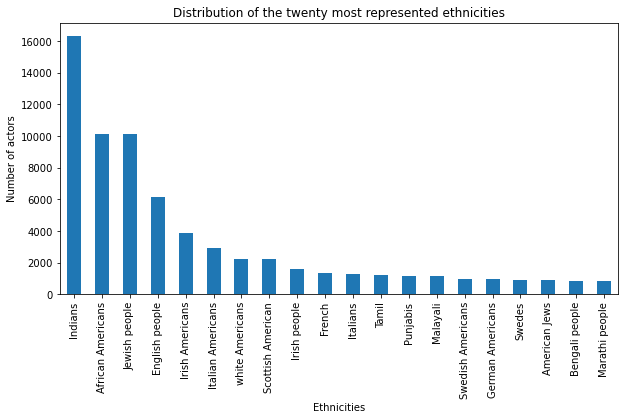

In [33]:
# Ethnicities visualization
plt.figure(figsize=(10,5))
characters.EthnicityName.value_counts()[:20].plot(kind="bar")
plt.xlabel('Ethnicities')
plt.ylabel('Number of actors')
plt.title('Distribution of the twenty most represented ethnicities');

In [34]:
print('The percentage of missing Ethnicity names is :', round(100*characters[['EthnicityName']].isna().sum().values[0]/n_char,2), '%')

The percentage of missing Ethnicity names is : 79.35 %


We only have the names of 20% of the actor ethnicities : this is not enough to base our analysis and to draw conclusions. We thus decided to not use the Ethnicity in our project.

### 1.4.2 Recovering Missing Actor Names  <a id='1.4.2'></a>

In addition, some actors do not have their name and/or date of birth and/or sex specified but the actor freebase ID is present. We can use the actor freebase ID to recover their Wikidata information. This gives us access to the following relevant information about the actor :
- Name
- Sex/Gender
- Date of Birth  
We can therefore replace the missing values in those categories, when the Actor Freebase ID is specified.

In [35]:
print('Number of rows where:\n\tActor is missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and DOB are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor, DOB and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tGender is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB and Gender are missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'] & ~characters['FreeActorID'].isna())]))

Number of rows where:
	Actor is missing but actor ID is specified : 413
	Actor and DOB are missing but actor ID is specified : 400
	Actor and Gender are missing but actor ID is specified : 401
	Actor, DOB and Gender are missing but actor ID is specified : 400
	DOB is missing but Actor and actor ID are specified : 104930
	Gender is missing but Actor and actor ID are specified : 44393
	DOB and Gender are missing but Actor and actor ID are specified : 62635


#### Starting with recovery of missing Actor names

For this, we perform the same as in the Ethnicity names recovery.

In [36]:
characters = characters.merge(maps, how="left", left_on="FreeActorID", right_on="free")
characters.drop(columns=["FreeActorID"], inplace=True)
characters.rename(columns={"wiki":"WikiActorID"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,free,WikiActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,/m/03wcfv7,Q1873468
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,NaN,/m/0346l4,Q230527
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,African Americans,/m/01vw26l,Q173637
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,NaN,/m/034hyc,Q169963
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,NaN,/m/01y9xg,Q233347


In [37]:
missing_actor = characters[(characters['ActorName'].isna() & ~characters['WikiActorID'].isna())]

In [38]:
map_WikiActorId_Actor = pd.DataFrame(missing_actor.WikiActorID.unique(), columns=["WikiActorID"]).dropna()
map_WikiActorId_Actor["ActorName"] = map_WikiActorId_Actor.WikiActorID.apply(get_wikidata_label)

In [39]:
characters = characters.merge(map_WikiActorId_Actor, how="left", left_on="WikiActorID", right_on="WikiActorID").drop(columns= ["WikiActorID", "WikiActorID"])
characters.drop(columns="free", inplace=True)

In [40]:
characters["ActorName"] = characters.fillna(value={"ActorName_x":""}).ActorName_x + characters.fillna(value={"ActorName_y":""}).ActorName_y
characters.drop(columns=["ActorName_x", "ActorName_y"], inplace=True)

In [41]:
characters.head()

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,ActorName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,Wanda De Jesus
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,27.0,/m/0jys3m,/m/0bgchn4,NaN,Natasha Henstridge
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,32.0,/m/0jys3g,/m/0bgchn_,African Americans,Ice Cube
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,33.0,/m/02vchl6,/m/0bgchnq,NaN,Jason Statham
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,23.0,/m/02vbb3r,/m/0bgchp9,NaN,Clea DuVall


From wikidata actor page,
- sex/gender (P21) is given as : male (Q6581097), female (Q6581072), intersex (Q1097630), transgender female (Q1052281), transgender male (Q2449503).
- date of birth (P569) is given as : Day of the month as a zero-padded decimal number, blank space, Month full name, blank space, Year with century as a decimal number. To recover the date of birth in the same format as the ones in the characters dataset, we must read the date given by wikidata without the blank spaces and then use datetime to format it correctly. See example just below :

In [42]:
wiki_date = '26 December 1949'
no_space = wiki_date.replace(" ", "")
date = datetime.strptime(no_space, '%d''%B''%Y')
formated_date = '{:%Y-%m-%d}'.format(date)
print(formated_date)

1949-12-26


We later decided that we won't use the actors information, so we didn't push further and didn't recover missing DOB or genders.

### Saving out results

Extracting from wikidata takes a few minutes so we can save our final `characters` dataframe in case we want to use that directly in further applications.

In [43]:
import os  
os.makedirs('data', exist_ok=True)  
characters.to_csv('data/characters_aug.tsv', sep="\t", index=False)

# 2. Plot Summaries   <a id='2'></a>

In [15]:
characters = pd.read_csv('data/characters_aug.tsv.gz', sep='\t', header=0, index_col=None)

The plot summaries are loaded from the file `plot_summaries.txt` and stored into `plot_summaries`dataset. 

In [18]:
plot_summaries = pd.read_csv('data/plot_summaries.txt', sep="\t", header=None,names=["WikiMovieID", "Plot"])
plot_summaries.head(3)

,WikiMovieID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...


## 2.1 Preprocessing  <a id='2.1'></a>

### 2.1.1 Missing plot summaries check  <a id='2.1.1'></a>

In [20]:
print('Number of missing plot summary in the plot_summary dataset: {}'.format(plot_summaries.Plot.isna().sum()))

Number of missing plot summary in the plot_summary dataset: 0


In [23]:
print('Number of missing plot summary when matched to films in movies dataset: {:.2f}%'.format((movies.merge(plot_summaries, how="left", on='WikiMovieID')).Plot.isna().sum()/len(movies)*100))

Number of missing plot summary when matched to films in movies dataset: 48.37%


We can see that we don't have the plot summary for about half of the movies.

### 2.1.2 Cleaning <a id='2.1.2'></a>

We detect the langage used in the plot summary and keep only the ones written in English.

In [25]:
movies.head(3)

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"


In [26]:
plot_summaries['lang'] = plot_summaries.Plot.progress_apply(detect)

100%|█████████████████████████████████████| 42303/42303 [08:18<00:00, 84.91it/s]


In [27]:
plot_summaries.lang.value_counts()

en    42275
id       14
es        6
de        4
sw        2
hi        1
et        1
Name: lang, dtype: int64

In [28]:
plot_summaries = plot_summaries.loc[plot_summaries.lang=='en']

### 2.1.3 Tokenization <a id='2.1.3'></a>

Tokenizers are used to divide strings into lists of substrings. For each `Plot` in `plot_summaries` dataset, a list of words and punctuation marks stored in the `words_punc` column, a list of sentences in `sentences` and a list of tokenized sentences `tokens_sentences`. To do so, we use the natural langage processing library `NLTK` (Natural Language Toolkit). "NLTK is a leading platform for building Python programs to work with human language data"[[3]](https://www.nltk.org/).

In [29]:
plot_summaries['words_punc'] = plot_summaries.Plot.progress_apply(lambda x: word_tokenize(x))
plot_summaries['sentences'] = plot_summaries.Plot.progress_apply(lambda x: sent_tokenize(x))
plot_summaries['tokens_sentences'] = plot_summaries['sentences'].progress_apply(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

100%|████████████████████████████████████| 42275/42275 [01:59<00:00, 353.56it/s]


### 2.1.4 PoS tagging <a id='2.1.4'></a>

Part-of-speech (POS) tagging is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. POS tags from the [*Penn Treebank* tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) are used to describe the lexical terms that we have within our plots.

In [30]:
plot_summaries['POS_tokens'] = plot_summaries['tokens_sentences'].progress_apply(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])

plot_summaries['POS_tokens'].head(3)

100%|█████████████████████████████████████| 42275/42275 [16:06<00:00, 43.74it/s]


0    [[(Shlykov, NNP), (,, ,), (a, DT), (hard-worki...
1    [[(The, DT), (nation, NN), (of, IN), (Panem, N...
2    [[(Poovalli, NNP), (Induchoodan, NNP), (is, VB...
Name: POS_tokens, dtype: object

### 2.1.5 Lemmatization <a id='2.1.5'></a>

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. It links words with similar meanings to one word. 

In [31]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [32]:
lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
plot_summaries['tokens_sentences_lemmatized'] = plot_summaries['POS_tokens'].progress_apply(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

plot_summaries[['Plot','tokens_sentences_lemmatized']].head(3)

100%|████████████████████████████████████| 42275/42275 [01:37<00:00, 432.17it/s]


,Plot,tokens_sentences_lemmatized
0,"Shlykov, a hard-working taxi driver and Lyosha...","[[Shlykov, ,, a, hard-working, taxi, driver, a..."
1,The nation of Panem consists of a wealthy Capi...,"[[The, nation, of, Panem, consist, of, a, weal..."
2,Poovalli Induchoodan is sentenced for six yea...,"[[Poovalli, Induchoodan, be, sentence, for, si..."


### 2.1.6 Regrouping tokens and removing stop words <a id='2.1.6'></a>

In order to extact interesting information from the words present in the plot summaries, we have to take into account only the meaningful words by removing insignificant ones called stop words.
What we have seen is that the names of the characters in the plot summaries create a lot of unwanted noise which in turn disturbs greatly our results in the topic extraction methods.Therefore, we introduce the [name-dataset](https://pypi.org/project/names-dataset/), which used a Facebook dump to create a first and last name database. From there  we extract the top 1000 first names for each gender and use them as stopwords. 

In [6]:
nd = NameDataset()
names = nd.get_top_names(n=2000, country_alpha2="US")
names = names["US"]["M"] + names["US"]["F"]
names = [name.lower() for name in names]

In [34]:
# Words gathered after running the LDA model and collecting the words appearing in more than 4 topics 
stops = ["one", "two", "also", "see", "take", "get", "find", "try", "however", "go", "come", "leave", "become", "make", "back", "run"]
my_stopwords = stopwords.words('English') + names + stops

plot_summaries['tokens'] = plot_summaries['tokens_sentences_lemmatized'].progress_apply(lambda sentences: list(chain.from_iterable(sentences)))

100%|███████████████████████████████████| 42275/42275 [00:04<00:00, 9254.71it/s]


In [35]:
plot_summaries['tokens'] = plot_summaries['tokens'].progress_apply(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

100%|█████████████████████████████████████| 42275/42275 [08:42<00:00, 80.93it/s]


### 2.1.7 Integration into movies dataset <a id='2.1.7'></a>

The preprocessed plot summaries `plot_summaries` are added to the `movies` dataset according to the Wikipedia movie ID, `WikiMovieID`. 

In [36]:
movies = movies.merge(plot_summaries, how="left", on='WikiMovieID') 

### 2.1.8 Preprocessing results <a id='2.1.8'></a>

In [38]:
movies[['Plot','words_punc','sentences','tokens_sentences','tokens']].head()

,Plot,words_punc,sentences,tokens_sentences,tokens
0,"Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, 22nd, ce...","[Set in the second half of the 22nd century, t...","[[Set, in, the, second, half, of, the, 22nd, c...","[set, second, half, century, film, depict, mar..."
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,A series of murders of rich young women throug...,"[A, series, of, murders, of, rich, young, wome...",[A series of murders of rich young women throu...,"[[A, series, of, murders, of, rich, young, wom...","[series, murder, woman, throughout, arizona, d..."
4,"Eva, an upper class housewife, becomes frustra...","[Eva, ,, an, upper, class, housewife, ,, becom...","[Eva, an upper class housewife, becomes frustr...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[upper, class, housewife, becomes, frustrated,..."


In [91]:
print(movies['Plot'][0])

Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a police officer, Melanie Ballard , second in command of a small team alongside Sergeant Jericho  sent to pick up and transport a prisoner named Desolation Williams . Arriving at the remote mining town where Williams is being held, Ballard finds virtually all of the people missing. She learns that the miners had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released "ghosts," disembodied spirits which possessed the miners. Violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. With their team leader Helena Bradock  murdered, Ballard must fight off the attacking miners, escape th

In [39]:
print(movies['POS_tokens'][0])

[[('Set', 'NN'), ('in', 'IN'), ('the', 'DT'), ('second', 'JJ'), ('half', 'NN'), ('of', 'IN'), ('the', 'DT'), ('22nd', 'JJ'), ('century', 'NN'), (',', ','), ('the', 'DT'), ('film', 'NN'), ('depicts', 'VBZ'), ('Mars', 'NNP'), ('as', 'IN'), ('a', 'DT'), ('planet', 'NN'), ('that', 'WDT'), ('has', 'VBZ'), ('been', 'VBN'), ('84', 'CD'), ('%', 'NN'), ('terraformed', 'VBN'), (',', ','), ('allowing', 'VBG'), ('humans', 'NNS'), ('to', 'TO'), ('walk', 'VB'), ('on', 'IN'), ('the', 'DT'), ('surface', 'NN'), ('without', 'IN'), ('wearing', 'VBG'), ('pressure', 'NN'), ('suits', 'NNS'), ('.', '.')], [('The', 'DT'), ('Martian', 'JJ'), ('society', 'NN'), ('has', 'VBZ'), ('become', 'VBN'), ('largely', 'RB'), ('matriarchal', 'JJ'), (',', ','), ('with', 'IN'), ('women', 'NNS'), ('in', 'IN'), ('most', 'JJS'), ('positions', 'NNS'), ('of', 'IN'), ('authority', 'NN'), ('.', '.')], [('The', 'DT'), ('story', 'NN'), ('concerns', 'VBZ'), ('a', 'DT'), ('police', 'NN'), ('officer', 'NN'), (',', ','), ('Melanie', 'NNP

In [40]:
print(movies['tokens_sentences_lemmatized'][0])

[['Set', 'in', 'the', 'second', 'half', 'of', 'the', '22nd', 'century', ',', 'the', 'film', 'depict', 'Mars', 'as', 'a', 'planet', 'that', 'have', 'be', '84', '%', 'terraformed', ',', 'allow', 'human', 'to', 'walk', 'on', 'the', 'surface', 'without', 'wear', 'pressure', 'suit', '.'], ['The', 'Martian', 'society', 'have', 'become', 'largely', 'matriarchal', ',', 'with', 'woman', 'in', 'most', 'position', 'of', 'authority', '.'], ['The', 'story', 'concern', 'a', 'police', 'officer', ',', 'Melanie', 'Ballard', ',', 'second', 'in', 'command', 'of', 'a', 'small', 'team', 'alongside', 'Sergeant', 'Jericho', 'send', 'to', 'pick', 'up', 'and', 'transport', 'a', 'prisoner', 'name', 'Desolation', 'Williams', '.'], ['Arriving', 'at', 'the', 'remote', 'mining', 'town', 'where', 'Williams', 'be', 'be', 'hold', ',', 'Ballard', 'find', 'virtually', 'all', 'of', 'the', 'people', 'miss', '.'], ['She', 'learn', 'that', 'the', 'miner', 'have', 'discover', 'an', 'underground', 'doorway', 'create', 'by', '

In [41]:
print(movies['tokens'][0])

['set', 'second', 'half', 'century', 'film', 'depict', 'mars', 'planet', 'terraformed', 'allow', 'human', 'walk', 'surface', 'without', 'wear', 'pressure', 'suit', 'martian', 'society', 'largely', 'matriarchal', 'woman', 'position', 'authority', 'story', 'concern', 'police', 'officer', 'ballard', 'second', 'command', 'small', 'team', 'alongside', 'sergeant', 'jericho', 'send', 'pick', 'transport', 'prisoner', 'name', 'desolation', 'arriving', 'remote', 'mining', 'town', 'hold', 'ballard', 'virtually', 'people', 'miss', 'learn', 'miner', 'discover', 'underground', 'doorway', 'create', 'ancient', 'martian', 'civilization', 'door', 'open', 'release', 'ghost', 'disembody', 'spirit', 'possess', 'miner', 'violence', 'ensues', 'possessed', 'miner', 'commit', 'horrific', 'act', 'death', 'destruction', 'well', 'team', 'leader', 'bradock', 'murder', 'ballard', 'must', 'fight', 'attack', 'miner', 'escape', 'town', 'destroy', 'ghost', 'possible', 'unfortunately', 'intention', 'complicate', 'fact',

#### Saving `movies`

In [42]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug.pkl')

In [ ]:
movies = pd.read_pickle('data/movies_aug.pkl')

## 2.2 Importing Metascore  <a id='2.2'></a>

When considering film rating, we can think about using the IMDb database. In particular, it provides the variable `averageRating` which is the weighted average of all the individual user ratings. However, IMDb user opinions can be given whenever the user wants. So, the ratings of IMDb do not match with the release date of the movie. It only works for analyzing the current opinions, as very recent reviews and can be written for an old film. 

In order to have an insigth into the movie impression at a time closer to the release date, we can consider metascore. [Metascore](https://github.com/miazhx/metacritic) is a weighted average of reviews from top published critic reviews for a given movie, and thus does not include any votes or comments from our users.


#### Metacritic dataset loading

We use a dataset which brings together the film title, release date, metascore and other scores. We load it and add the `metascore` information into the `movie` dataset.

In [46]:
metacritic_url = "https://raw.githubusercontent.com/miazhx/metacritic/master/data/metacritic_movies.csv"

metacritic = pd.read_csv(metacritic_url)

In [47]:
metacritic.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore
0,Anatomy of a Murder,1-Jul-59,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd
1,Bringing Up Baby,18-Feb-38,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd
2,After Life,12-May-99,"Drama,Fantasy",0,0,19,91,0,2,1,tbd
3,Gavagai,3-Aug-18,Drama,1,0,6,91,0,1,2,tbd
4,The Hustler,25-Sep-61,"Drama,Sport",1,0,17,90,0,0,3,tbd


#### Missing value check

In [48]:
print('Number of missing metascore in metacritic dataset: {}'.format(metacritic['metascore'].isna().sum()))

Number of missing metascore in metacritic dataset: 0


In [50]:
print('There are {} metascores for {} movies (including {} with plot summary available).'.format(len(metacritic),len(movies), (len(movies)-movies.Plot.isna().sum())))

There are 9121 metascores for 81741 movies (including 42176 with plot summary available).


#### Sub-dataset with the features we are interested in

In [51]:
metacritic_score = metacritic[['movie_title','metascore','release_date']].rename(columns = {'movie_title':'Title'})

In [53]:
metacritic_score.head(3)

,Title,metascore,release_date
0,Anatomy of a Murder,95,1-Jul-59
1,Bringing Up Baby,91,18-Feb-38
2,After Life,91,12-May-99


In [60]:
metacritic_score.release_date[[0]]

0    1-Jul-59
Name: release_date, dtype: object

In [68]:
date=pd.to_datetime(metacritic_score.release_date[[0]], format='%d-%b-%y')
date

0   2059-07-01
Name: release_date, dtype: datetime64[ns]

In [69]:
metacritic['release_date_'] = pd.to_datetime(metacritic['release_date'], format='%d-%b-%y')

In [80]:
metacritic['year_last_digits']=metacritic['release_date_'].apply( lambda x: x.year-2000 )

In [59]:
pd.to_datetime(movies['ReleaseDate']).head()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1010-12-02 00:00:00

In [58]:
metacritic_score.head(3)

,Title,metascore,release_date
0,Anatomy of a Murder,95,1-Jul-59
1,Bringing Up Baby,91,18-Feb-38
2,After Life,91,12-May-99


In [ ]:
metacritic['release_date'] 

In [108]:
# Trying to convert release_date to date time, in order to compare the movies release date and the metacritic release date
# => handle metascore for the movie series (same title but different release date)
#metacritic_score["release_date"] = metacritic_score["release_date"].apply( lambda x:'{:%Y-%m-%d}'.format(x.replace(" ", "").strptime(no_space, '%d''%B''%Y')))

In [56]:
metacritic_score["release_date"].apply( lambda x:'{:%Y-%m-%d}'.format(x.replace(" ", "").strptime(no_space, '%d''%B''%Y'))).head()

AttributeError: 'str' object has no attribute 'strptime'

#### Adding metascores to the `movies` dataset

In [139]:
movies = movies.merge(metacritic_score, how="left", on="Title") # Not really sure how this works but there's no duplicates or sth

In [140]:
movies.head()

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,lang,words_punc,sentences,tokens_sentences,POS_tokens,tokens_sentences_lemmatized,tokens,metascore,release_date
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",en,"[Set, in, the, second, half, of, the, 22nd, ce...","[Set in the second half of the 22nd century, t...","[[Set, in, the, second, half, of, the, 22nd, c...","[[(Set, NN), (in, IN), (the, DT), (second, JJ)...","[[Set, in, the, second, half, of, the, 22nd, c...","[set, second, half, century, film, depict, mar...",35.0,24-Aug-01
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,en,"[A, series, of, murders, of, rich, young, wome...",[A series of murders of rich young women throu...,"[[A, series, of, murders, of, rich, young, wom...","[[(A, DT), (series, NN), (of, IN), (murders, N...","[[A, series, of, murder, of, rich, young, woma...","[series, murder, woman, throughout, arizona, d...",NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",en,"[Eva, ,, an, upper, class, housewife, ,, becom...","[Eva, an upper class housewife, becomes frustr...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[[(Eva, NNP), (,, ,), (an, DT), (upper, JJ), (...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[upper, class, housewife, becomes, frustrated,...",NaN,NaN


In [141]:
print("Missing metascores in movies dataset: {:.2f}%".format(movies['metascore'].isna().sum()/len(movies)*100))

Missing metascores in movies dataset: 90.50%


## 2.3 Initial analysis  <a id='2.3'></a>

In [142]:
#Check the state of our dataset
movies.head(3)

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,lang,words_punc,sentences,tokens_sentences,POS_tokens,tokens_sentences_lemmatized,tokens,metascore,release_date
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",en,"[Set, in, the, second, half, of, the, 22nd, ce...","[Set in the second half of the 22nd century, t...","[[Set, in, the, second, half, of, the, 22nd, c...","[[(Set, NN), (in, IN), (the, DT), (second, JJ)...","[[Set, in, the, second, half, of, the, 22nd, c...","[set, second, half, century, film, depict, mar...",35.0,24-Aug-01
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,en,"[A, series, of, murders, of, rich, young, wome...",[A series of murders of rich young women throu...,"[[A, series, of, murders, of, rich, young, wom...","[[(A, DT), (series, NN), (of, IN), (murders, N...","[[A, series, of, murder, of, rich, young, woma...","[series, murder, woman, throughout, arizona, d...",NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",en,"[Eva, ,, an, upper, class, housewife, ,, becom...","[Eva, an upper class housewife, becomes frustr...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[[(Eva, NNP), (,, ,), (an, DT), (upper, JJ), (...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[upper, class, housewife, becomes, frustrated,...",NaN,NaN


### 2.3.1 Plot structure <a id='2.3.1'></a>

Here, for each plot summary, we investigate the number of sentences, number of words, numbers of the different punctuation marks.

We work on the `plot_summarie` dataset, adding new columns (`plot_num_sentences`,`plot_num_words`,`plot_num_dot`,`plot_num_coma`,`plot_num_interrogation`,``````

In [119]:
# Moving back to plot_summaries to avoid nan values
plot_summaries['plot_num_sentences'] = plot_summaries.sentences.apply( lambda x: len(x))
plot_summaries['plot_num_words'] =  plot_summaries.Plot.apply( lambda x: len(RegexpTokenizer(r'\w+').tokenize(x)))
plot_summaries['plot_num_dot'] = plot_summaries.words_punc.apply( lambda x: list(x).count('.'))
plot_summaries['plot_num_coma'] = plot_summaries.words_punc.apply( lambda x: x.count(','))
plot_summaries['plot_num_interrogation'] = plot_summaries.words_punc.apply( lambda x: x.count('?'))
plot_summaries['plot_num_exclamation'] = plot_summaries.words_punc.apply( lambda x: x.count('!'))
plot_summaries['plot_num_percentage'] = plot_summaries.words_punc.apply( lambda x: x.count('%'))
plot_summaries['plot_num_semicolon'] = plot_summaries.words_punc.apply( lambda x: x.count(';'))
plot_summaries['plot_num_colon'] = plot_summaries.words_punc.apply( lambda x: x.count(':'))

plot_summaries[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',\
        'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].head()

,plot_num_sentences,plot_num_words,plot_num_dot,plot_num_coma,plot_num_interrogation,plot_num_exclamation,plot_num_percentage,plot_num_semicolon,plot_num_colon
0,1,28,1,5,0,0,0,0,0
1,52,789,52,48,0,0,0,3,0
2,26,493,26,23,0,0,0,0,0
3,49,866,49,51,0,0,0,0,0
4,15,408,15,26,0,0,0,0,0


#### 2.3.1.1 Statistics

In [120]:
plot_summaries[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',\
                'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].describe().apply("{0:.3f}".format)

,plot_num_sentences,plot_num_words,plot_num_dot,plot_num_coma,plot_num_interrogation,plot_num_exclamation,plot_num_percentage,plot_num_semicolon,plot_num_colon
count,42276.000000,42276.000000,42276.000000,42276.000000,42276.000000,42276.000000,42276.000000,42276.000000,42276.000000
mean,15.693585,316.079052,15.458180,18.626975,0.079194,0.088703,0.009012,0.415129,0.303908
std,16.598726,323.456430,16.507334,20.718703,0.449321,0.560378,0.283409,1.202210,0.929971
min,1.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,89.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,190.000000,9.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23.000000,460.000000,23.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,344.000000,5016.000000,333.000000,307.000000,30.000000,27.000000,52.000000,65.000000,48.000000


#### 2.3.1.2 Visualizations

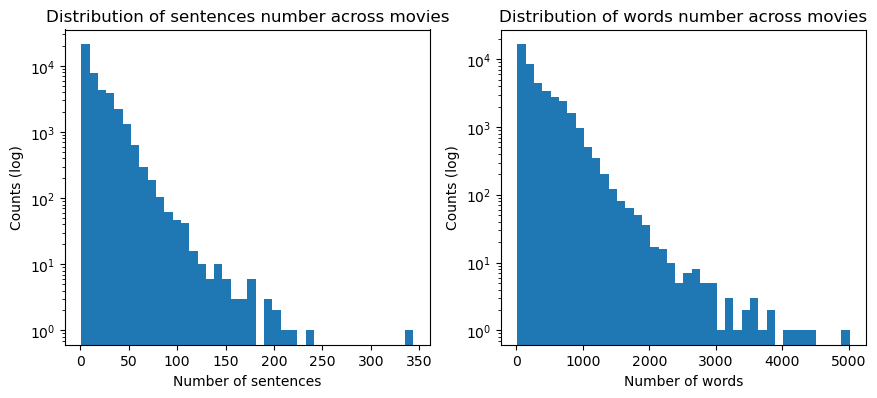

In [43]:
#/!!!!\working with movies_aug2 after removing rows with no plot summary

fig, axs = plt.subplots(1, 2, figsize=(9,4))
fig.tight_layout(pad=3)
axs[0].hist(movies.plot_num_sentences,bins=40,log=True)
axs[0].set_title('Distribution of sentences number across plot summaries')
axs[0].set_xlabel('Number of sentences')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_words,bins=40,log=True)
axs[1].set_title('Distribution of words number across plot summaries')
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Counts (log)')

plt.show()

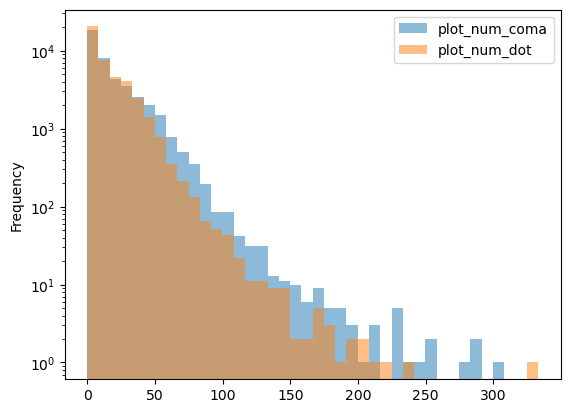

In [55]:
punctuation1 = movies[['plot_num_coma','plot_num_dot']]
punctuation1.plot.hist(bins=40, log=True, alpha=0.5)
plt.title('Distribution of coma and dot number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

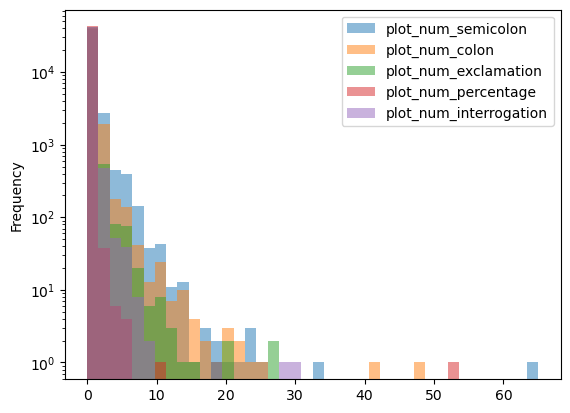

In [56]:
punctuation2 = movies[['plot_num_semicolon','plot_num_colon','plot_num_exclamation','plot_num_percentage','plot_num_interrogation']]
punctuation2.plot.hist(bins=40, log=True, alpha=0.5)
plt.title('Distribution of exclamation points, interrogation points, semicolon, colon, \nand percent symbol number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

In [39]:
#put this graph in 2.3.2
#genre_words = pd.crosstab(movies['Genres',movies['plot_top_ten_tokens']])
#sns.heatmap(genre_words, annot=True, vmin=0, vmax=10)

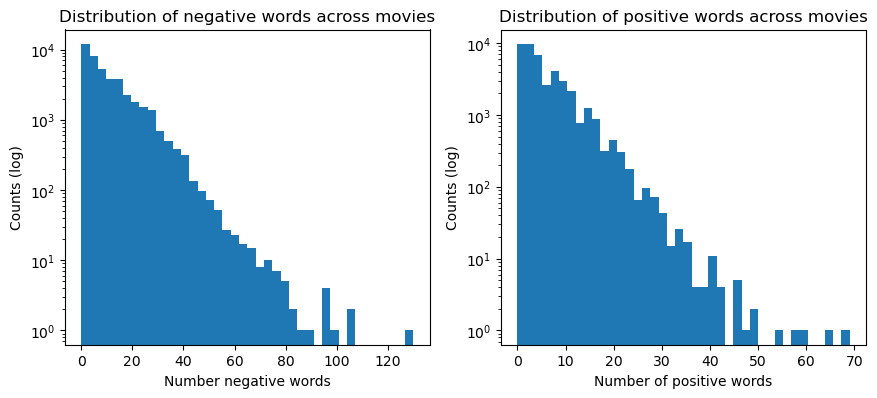

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
fig.tight_layout(pad=2)
axs[0].hist(movies.plot_num_negative,bins=40,log=True)
axs[0].set_title('Distribution of negative words across movies')
axs[0].set_xlabel('Number negative words')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_positive,bins=40,log=True)
axs[1].set_title('Distribution of positive words across movies')
axs[1].set_xlabel('Number of positive words')
axs[1].set_ylabel('Counts (log)')

plt.show()

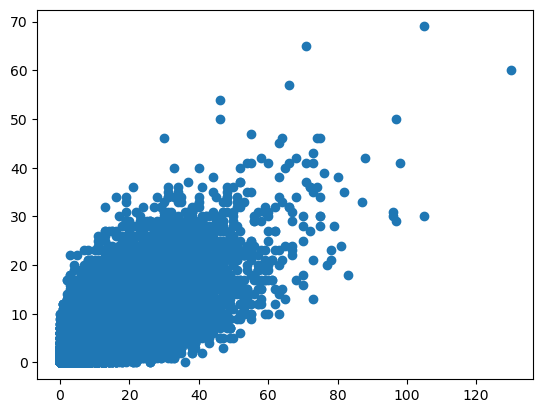

In [57]:
plt.scatter(movies.plot_num_negative, movies.plot_num_positive)
plt.title('Relationship between number of negative words and number of \npositive words in plot summaries')
plt.xlabel('Number of negative words')
plt.ylabel('Number of positive words')
plt.show()

### 2.3.2 Most common tokens in plot summaries <a id='2.3.2'></a>

In [122]:
def most_frequent(List,n):
    occurence_count = Counter(List)
    return occurence_count.most_common(n)

In [123]:
plot_summaries['plot_top_ten_tokens'] = plot_summaries.tokens.apply( lambda x: most_frequent(x,10))

plot_summaries['plot_top_ten_tokens'].head() 

0    [(shlykov, 1), (taxi, 1), (driver, 1), (lyosha...
1    [(katniss, 24), (peeta, 16), (rue, 11), (distr...
2    [(induchoodan, 18), (menon, 12), (manapally, 8...
3    [(kid, 34), (home, 10), (moran, 8), (money, 7)...
4    [(azaria, 4), (guilty, 3), (wife, 2), (baby, 2...
Name: plot_top_ten_tokens, dtype: object

### 2.3.3 Words polarity <a id='2.3.3'></a>

In [125]:
#count of the different negative and positive words
positive_txt = requests.get('https://ptrckprry.com/course/ssd/data/positive-words.txt').text
negative_txt = requests.get('https://ptrckprry.com/course/ssd/data/negative-words.txt').text

def parse_str(s):
    return list(filter(lambda x:x[0]!=';', list(filter(None, s.split("\n")))))

In [126]:
plot_summaries['plot_num_positive']= plot_summaries.Plot.apply(lambda x : len(set(parse_str(positive_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))
plot_summaries['plot_num_negative']= plot_summaries.Plot.apply(lambda x : len(set(parse_str(negative_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))

plot_summaries[['plot_num_positive','plot_num_negative']].head()

,plot_num_positive,plot_num_negative
0,1,4
1,17,33
2,10,23
3,19,23
4,4,14


#### Saving `movies`

In [143]:
merging_cols = list(plot_summaries.columns.difference(movies.columns)) + ["WikiMovieID"]
movies = movies.merge(plot_summaries[merging_cols], how="left", on="WikiMovieID")

In [146]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug2.pkl')

In [5]:
movies = pd.read_pickle('data/movies_aug2.pkl')

In [6]:
movies = movies.dropna(subset=['Plot'])

### 2.3.4 Ratings <a id='2.3.4'></a>

### 2.3.5 Combined information <a id='2.3.5'></a>

# 3. Topic Extraction <a id='3'></a>

## 3.1 LDA <a id='3.1'></a>

### 3.1.1 Data preparation <a id='3.1.1'></a>

#### Prepare bi-grams and tri-grams

In [150]:
tokens = plot_summaries['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [151]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

### 3.1.2 Implementation <a id='3.1.2'></a>

In [152]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 1min 41s, sys: 572 ms, total: 1min 41s
Wall time: 1min 42s


### 3.1.3 Model evaluation <a id='3.1.3'></a>

(by checking how many topics a word exists in)

In [153]:
topics_ = dict()
for i,topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    topics_[i]=topic

In [156]:
"""
Counts for each word the number of topics that include it
"""
def count_words(topics_):
    counts = dict()
    for i in topics_:
        for word in topics_[i]:
            if word[0] in counts:
                counts[word[0]]+=1
            else:
                counts[word[0]]=1
    return counts

def takeSecond(elem):
    return elem[1]

In [157]:
counts = count_words(topics_)
repeated_words = [(k,v) for k,v in counts.items() if v>=4]
repeated_words.sort(reverse=True, key = takeSecond)
repeated_words

[('woman', 5),
 ('fall', 5),
 ('life', 4),
 ('play', 4),
 ('give', 4),
 ('meet', 4),
 ('time', 4),
 ('escape', 4),
 ('men', 4),
 ('attack', 4),
 ('begin', 4),
 ('group', 4)]

### 3.1.4 Resulting topics <a id='3.1.4'></a>

In [158]:
for i in topics_:
    message = "Topic {} : ".format(i) 
    words = str([k for (k,v) in topics_[i]])
    print(message+words)
    print()

Topic 0 : ['story', 'raja', 'uncle', 'life', 'hollis', 'kang', 'expand_section', 'lambert', 'cite_web', 'play', 'follow', 'idol', 'guru', 'poet', 'bergman', 'millionaire', 'film_tell_story', 'child', 'woman', 'set']

Topic 1 : ['money', 'boy', 'kid', 'steal', 'work', 'gang', 'sell', 'bank', 'pay', 'plan', 'give', 'car', 'decide', 'big', 'new', 'company', 'business', 'buy', 'owner', 'town']

Topic 2 : ['family', 'mother', 'life', 'father', 'friend', 'child', 'meet', 'wife', 'marry', 'husband', 'live', 'work', 'home', 'woman', 'daughter', 'decide', 'relationship', 'time', 'return', 'fall']

Topic 3 : ['kill', 'police', 'escape', 'men', 'shoot', 'murder', 'tell', 'help', 'meet', 'plan', 'fight', 'reveal', 'brother', 'death', 'arrive', 'arrest', 'later', 'gun', 'gang', 'attack']

Topic 4 : ['japanese', 'camp', 'spike', 'bowen', 'japan', 'lion', 'korea', 'tokyo', 'circus', 'mace', 'sullivan', 'whitey', 'toshio', 'tarzan', 'preacher', 'korean', 'finch', 'mississippi', 'pa', 'winter']

Topic 

### 3.1.5 Topic Visualizations <a id='3.1.5'></a>

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### 3.1.6 Assigning topics to movies <a id='3.1.6'></a>

In [159]:
def most_probable_topic(possible_topics):
    possible_topics.sort(reverse=True, key = takeSecond)
    return possible_topics[0][0]

In [160]:
chosen_topics = list()
for plot in tqdm(corpus):
    possible_topics = lda_model[plot]
    chosen_topic = most_probable_topic(possible_topics)
    chosen_topics.append(chosen_topic)

chosen_topics = np.array(chosen_topics)

100%|███████████████████████████████████| 42276/42276 [00:18<00:00, 2309.42it/s]


In [161]:
topics_df = pd.DataFrame(chosen_topics, columns = ["Topic"]) #Rename this to Topic_LDA

topics_df["Index"] = topics_df.index

display(topics_df.head())

,Topic,Index
0,2,0
1,19,1
2,16,2
3,1,3
4,16,4


In [163]:
plot_summaries["Index"] = plot_summaries.index

plot_summaries = plot_summaries.merge(topics_df, left_on="Index", right_on="Index").drop(columns=["Index"])

In [165]:
plot_summaries[["WikiMovieID", "Plot", "Topic"]].head() # Can merge again with movies 

,WikiMovieID,Plot,Topic
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",2
1,31186339,The nation of Panem consists of a wealthy Capi...,19
2,20663735,Poovalli Induchoodan is sentenced for six yea...,16
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",1
4,595909,Seventh-day Adventist Church pastor Michael Ch...,16


#### Saving `movies`

In [166]:
merging_cols = list(plot_summaries.columns.difference(movies.columns)) + ["WikiMovieID"]
movies = movies.merge(plot_summaries[merging_cols], how="left", on="WikiMovieID")

In [168]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug3.pkl')

In [6]:
movies = pd.read_pickle('data/movies_aug3.pkl')

## 3.2 BERTopic <a id='3.2'></a>

### 3.2.1 Data preparation <a id='3.2.1'></a>

In [15]:
# List of docs
docs = movies[~movies.Plot.isna()].Plot.tolist()

# List of punctuation marks
punctuations = list()
for punctuation in string.punctuation:
    punctuations.append(punctuation)

# Stopwords to use
stop_words = list(set(stopwords.words('english'))) + punctuations + names

# Tokenization : List of Lists of Tokens
docs_tokenized = [word_tokenize(doc) for doc in docs]

# Removing the stopwords
filtered_docs = list()
for doc in tqdm(docs_tokenized):
    filtered_doc = " ".join([w.lower() for w in doc if not w.lower() in stop_words])
    filtered_docs.append(filtered_doc)

100%|████████████████████████████████████| 42490/42490 [05:23<00:00, 131.41it/s]


### 3.2.2 Implementation <a id='3.2.2'></a>

BERT is a transformer-based machine learning technique which is unfortunately extremely heavy (?) computation wise. Therefore, we decided to execute it in google colab to utilise the provided gpu. The instructions followed there are the same as the ones portrayed in this notebook. We then saved the model and its predictions. The model can be found in this [drive](https://www.google.com) UPDATE LINK

In [1]:
model = BERTopic(language="english")
topics, probs = model.fit_transform(filtered_docs)

### 3.2.3 Model Evaluation <a id='3.2.3'></a>

We saved our model form cloud using `pickle` and the equivalent command given by the `bertopic` library. However when we try to load them we get the following error message : *RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU*. We don't really need this step to continue our analysis but it would be nice to load it as we can show the words associated to each topic and therefore the reason why we chose to name for each topic.

In [31]:
#model = BERTopic.load('models/BERTopic')
#model = pickle.load(open('models/bert_model', 'rb'))

### 3.2.4 Predictions <a id='3.2.4'></a>

In [7]:
bert_predictions = pd.read_pickle('predictions/bert_predictions.pkl')

bert_predictions.rename(columns={"Topic":"BERT"}, inplace=True)

### 3.2.5 Topic Visualizations <a id='3.2.5'></a>

### 3.2.6 Assigning topics to movies <a id='3.2.6'></a>

In [18]:
movies = movies.merge(bert_predictions, how="left", on="WikiMovieID")
movies[["Plot", "BERT"]].head()

,Plot,BERT
0,"Set in the second half of the 22nd century, th...",-1.0
1,NaN,NaN
2,NaN,NaN
3,A series of murders of rich young women throug...,0.0
4,"Eva, an upper class housewife, becomes frustra...",-1.0


# 4. Milestone 3 <a id='4'></a>